<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/AgeEstimation_optos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AgeEstimation_Optos**

##**Load pretrained weight**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 必要ライブラリ読み込み
!pip install timm==0.5.4 --q #timmのバージョンが違うとうまくstate dictできないので注意！！！
import random
import timm
import copy
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from timm.scheduler import CosineLRScheduler
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import os
import glob
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
import time
import matplotlib.pyplot as plt
%matplotlib inline




# モデル枠組み読み込み
model = timm.create_model(model_name='swin_base_patch4_window12_384', num_classes=1, pretrained=False)

# GPU使用する場合
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# 学習済みモデル読み込み
model_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/model_20220903.pth'
#model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.load_state_dict(torch.load(model_path))


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 15.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


cuda:0


<ipython-input-1-a1c09bba1014>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
optos_dir = "/content/drive/MyDrive/Deep_learning/FundusPhoto/Optos"
jpg_files = [f for f in os.listdir(optos_dir) if f.endswith('.jpg')]

# 結果を表示
jpg_files


['211034_20241017_114403_Optos_L_64_M.jpg',
 '210907_20240924_113602_Optos_L_52_M.jpg',
 '210906_20240924_113252_Optos_R_52_M.jpg',
 '210810_20240904_155929_Optos_R_46_F.jpg',
 '210801_20240903_111748_Optos_R_50_F.jpg',
 '210800_20240902_162824_Optos_R_50_F.jpg',
 '210799_20240902_152327_Optos_L_75_M.jpg',
 '210797_20240902_134304_Optos_L_78_M.jpg',
 '210781_20241018_105426_Optos_L_57_M.jpg']

<ipython-input-8-af3e3dd2c9ae>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


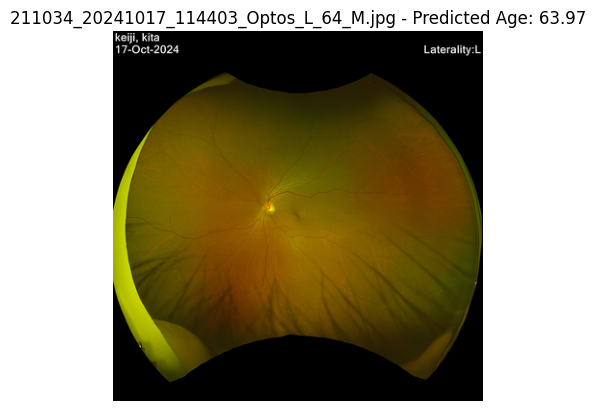

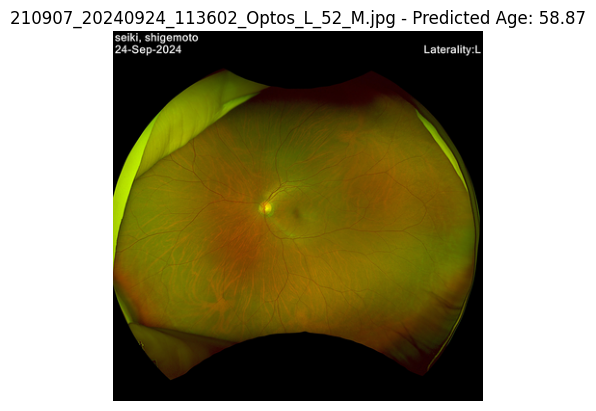

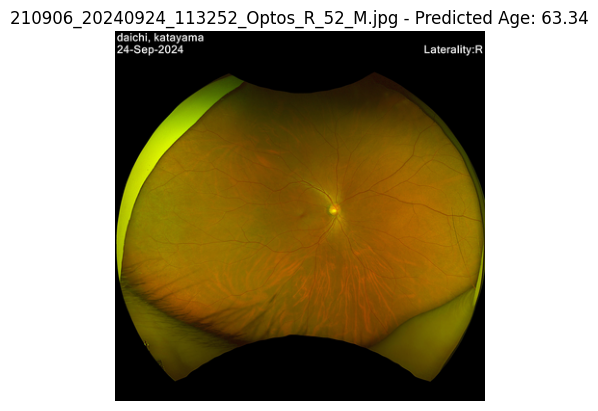

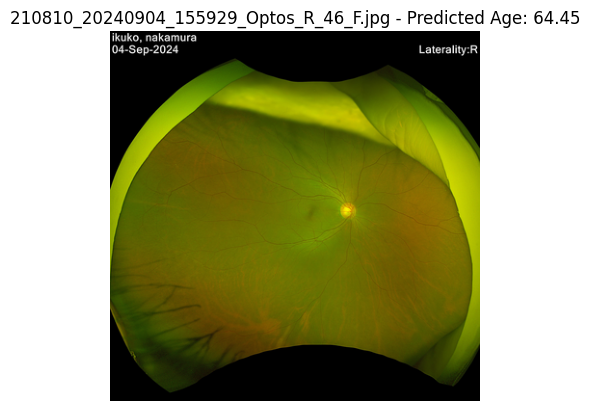

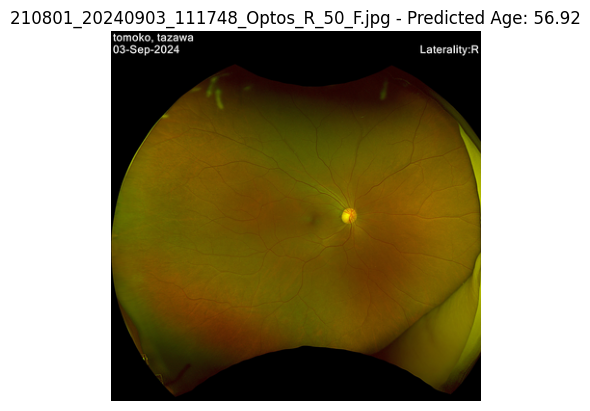

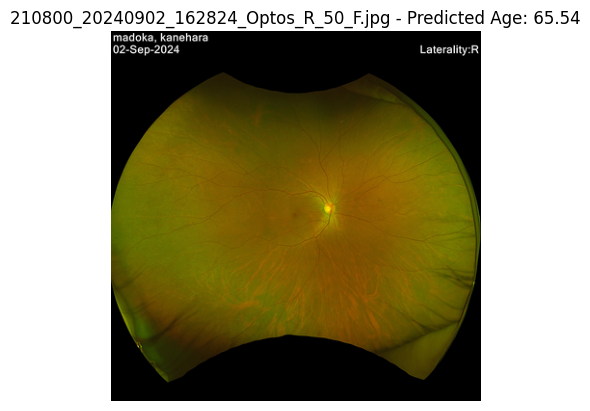

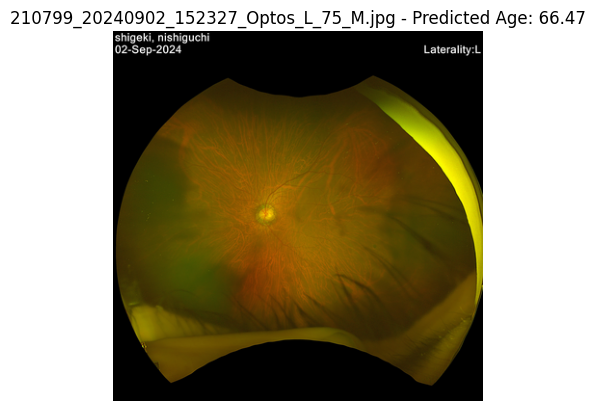

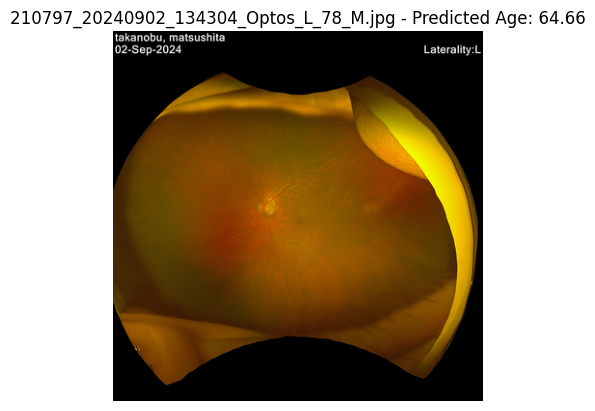

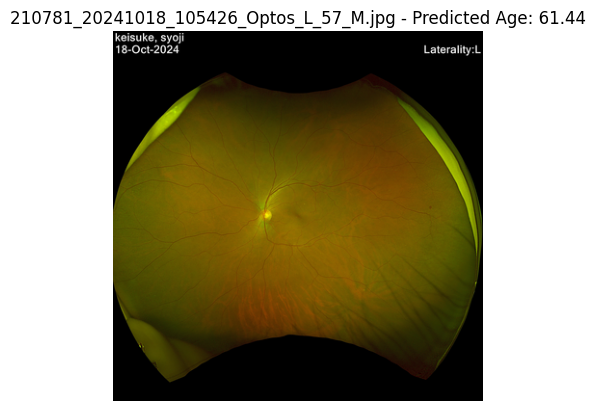

In [ ]:
import torch
import timm
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os

# 設定
model_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/finetuned_model/age.pth'
img_dir = "/content/drive/MyDrive/Deep_learning/FundusPhoto/Optos"

# デバイス設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 画像変換設定
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 画像を読み込み、正方形にクロップして384x384にリサイズ
def preprocess_image(img_path, target_size=384):
    image = Image.open(img_path).convert('RGB')

    # 短辺に合わせて正方形にクロップ
    width, height = image.size
    min_dim = min(width, height)
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim
    image = image.crop((left, top, right, bottom))

    # 384x384にリサイズ
    image = image.resize((target_size, target_size), Image.LANCZOS)

    return image

# モデルの読み込み
model = timm.create_model('swin_base_patch4_window12_384', num_classes=1, pretrained=False)
model.load_state_dict(torch.load(model_path))
model.eval()
model = model.to(device)

# img_dir 内のすべての画像に対して推論と表示
for file_name in os.listdir(img_dir):
    if file_name.endswith('.jpg'):
        img_path = os.path.join(img_dir, file_name)

        # 画像の前処理
        image = preprocess_image(img_path)
        image_tensor = transform(image).unsqueeze(0).to(device)

        # 推論
        with torch.no_grad():
            pred_age = model(image_tensor).item()

        # 画像と推論結果の表示
        plt.imshow(image)
        plt.title(f"{file_name} - Predicted Age: {pred_age:.2f}")
        plt.axis('off')
        plt.show()
